In [12]:
from model.patch_model import GeoLocalizationNet

model = GeoLocalizationNet("resnet18", 512)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

backbone test
torch.Size([2, 512, 7, 7])


In [13]:
import torch

#model_state_dict = torch.load("logs/default/best_model.pth")
model_state_dict = torch.load("logs/default/resnet18_512.pth")

In [14]:
model_state_dict["p"] = model_state_dict['aggregation.1.p']
model_state_dict['projection.weight'] = model_state_dict['aggregation.3.weight']
model_state_dict['projection.bias'] = model_state_dict['aggregation.3.bias']

del model_state_dict['aggregation.1.p']
del model_state_dict['aggregation.3.weight']
del model_state_dict['aggregation.3.bias']

In [15]:
model.load_state_dict(model_state_dict)

<All keys matched successfully>

In [16]:
from datasets.test_dataset import TestDataset

test_ds_tokyo = TestDataset("/content/tokyo_xs/test/",positive_dist_threshold=25)
val_ds = TestDataset("/content/small/val/",positive_dist_threshold=25)
test_sf_n = TestDataset("/content/small/test/", queries_folder="OK_final", positive_dist_threshold=25)
test_sf = TestDataset("/content/small/test/", queries_folder="queries_v1", positive_dist_threshold=25)

In [17]:
from dataclasses import dataclass

@dataclass
class Args:
  num_workers: int
  infer_batch_size: int
  device: str
  fc_output_dim: int
  recall_values: object
  positive_dist_threshold: int
  top_knn_value: int

args = Args(2, 8, "cuda", 512, [1, 5, 10, 20], 25, 20)

In [18]:
import gc

import faiss
import torch
import logging
import numpy as np
from tqdm import tqdm
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Subset
from patch_matcher import compare_two_spatial_approximation, compare_two_ransac, calc_keypoint_centers_from_patches, torch_nn
from functools import partial


import numpy as np
import torch
import cv2
from math import inf


STRIDE = 1


def find_matches(q_local, p_local, tollerance=inf):

  x = torch.FloatTensor(q_local)
  y = torch.FloatTensor(p_local)

  dist = torch.cdist(x.T, y.T)

  fw_inds = torch.argmin(dist, 0)
  bw_inds = torch.argmin(dist, 1)

  fw_inds = fw_inds.cpu().numpy()
  bw_inds = bw_inds.cpu().numpy()

  db_mutuals = np.atleast_1d(np.argwhere(bw_inds[fw_inds] == np.arange(len(fw_inds))).squeeze())

  q_mutuals = fw_inds[db_mutuals]

  mutual_distances = dist[q_mutuals, db_mutuals].cpu().numpy()
  treshold = np.mean(mutual_distances) + tollerance * np.std(mutual_distances)

  good_matches = np.where(mutual_distances <= treshold)
  q_mutuals = q_mutuals[good_matches]
  db_mutuals = db_mutuals[good_matches]

  return q_mutuals, db_mutuals


def compare_two_spatial_approximation(qfeat, dbfeats, output_shape_q, output_shape_db, stride=STRIDE, tollerance=inf):
        indices_q = calc_keypoint_centers_from_patches(output_shape_q, stride)
        indices_db = calc_keypoint_centers_from_patches(output_shape_db, stride)

        q_mutuals, db_mutuals = find_matches(qfeat, dbfeats, tollerance=tollerance)

        if len(q_mutuals) > 0:
            index_keypoints = indices_db[:, db_mutuals]
            query_keypoints = indices_q[:, q_mutuals]

            spatial_dist = index_keypoints - query_keypoints # manhattan distance works reasonably well and is fast
            mean_spatial_dist = np.mean(spatial_dist, axis=1)

            # residual between a spatial distance and the mean spatial distance. Smaller is better
            s_dists_x = spatial_dist[0, :] - mean_spatial_dist[0]
            s_dists_y = spatial_dist[1, :] - mean_spatial_dist[1]
            s_dists_x = np.absolute(s_dists_x)
            s_dists_y = np.absolute(s_dists_y)

            # anchor to the maximum x and y axis index for the patch "feature space"
            xmax = max([np.max(indices_q[0, :]), np.max(indices_db[0, :])])
            ymax = max([np.max(indices_q[1, :]), np.max(indices_db[1, :])])

            # find second-order residual, by comparing the first residual to the respective anchors
            # after this step, larger is now better
            # add non-linearity to the system to excessively penalise deviations from the mean
            s_score = (xmax - s_dists_x)**2 + (ymax - s_dists_y)**2
            s_score = - s_score.sum()/qfeat.shape[1]

        else:
            s_score = 0.

        return s_score


def compare_two_ransac(qfeat, dbfeats, output_shape_q, output_shape_db, stride=1):
        keypoints_q = calc_keypoint_centers_from_patches(output_shape_q, stride)
        keypoints_db = calc_keypoint_centers_from_patches(output_shape_db, stride)

        qfeat = torch.FloatTensor(qfeat)
        dbfeats = torch.FloatTensor(dbfeats)

        fw_inds, bw_inds = torch_nn(qfeat, dbfeats)
        fw_inds = fw_inds.cpu().numpy()
        bw_inds = bw_inds.cpu().numpy()

        mutuals = np.atleast_1d(np.argwhere(bw_inds[fw_inds] == np.arange(len(fw_inds))).squeeze())

        if len(mutuals) > 0:
            index_keypoints = keypoints_db[:, mutuals]
            query_keypoints = keypoints_q[:, fw_inds[mutuals]]

            index_keypoints = np.transpose(index_keypoints)
            query_keypoints = np.transpose(query_keypoints)

            _, mask = cv2.findHomography(index_keypoints, query_keypoints, cv2.FM_RANSAC, ransacReprojThreshold=stride*1.5)

            inlier_index_keypoints = index_keypoints[mask.ravel() == 1]
            inlier_count = inlier_index_keypoints.shape[0]
            s_score = -inlier_count / qfeat.shape[1]

        else:
            s_score = 0.

        return s_score


def test_with_postprocessing(args, eval_ds, model, method="rapid", tollerance=inf, patch_size=3, stride=1):


    global database_subset_ds
    global queries_subset_ds
    global positives_per_query
    global predictions
    global reranked_predictions
    global queries_local_descriptors
    global database_local_descriptors
    global output_shape_db
    global all_output_shape_q



    if method =="rapid":
        compare_two = partial(compare_two_spatial_approximation, stride=stride, tollerance=tollerance)
    elif method=="ransac":
        compare_two = partial(compare_two_ransac, stride=stride)


    model = model.eval()
    with torch.no_grad():
        logging.debug("Extracting database descriptors for evaluation/testing")
        database_subset_ds = Subset(eval_ds, list(range(eval_ds.database_num)))
        database_dataloader = DataLoader(dataset=database_subset_ds, num_workers=args.num_workers,
                                        batch_size=args.infer_batch_size, pin_memory=(args.device=="cuda"))

        all_global_descriptors = np.empty((len(eval_ds), args.fc_output_dim), dtype="float32")
        all_local_descriptors = [None for _ in range(len(eval_ds))]

        for images, indices in tqdm(database_dataloader, ncols=100):
            descriptors = model.embedd(images.to(args.device))
            global_descriptors, local_descriptor = model.local_pool(descriptors, patch_sizes_list=(patch_size,))
            local_descriptor = local_descriptor[0]

            global_descriptors = global_descriptors.cpu().numpy()
            local_descriptor = local_descriptor.cpu().numpy()

            all_global_descriptors[indices.numpy(), :] = global_descriptors

            indices = indices.numpy()
            for ind in range(len(indices)):
                all_local_descriptors[indices[ind]] = local_descriptor[ind]

        output_shape_db = (descriptors.shape[2], descriptors.shape[3])


        logging.debug("Extracting queries descriptors for evaluation/testing using batch size 1")
        queries_infer_batch_size = 1
        queries_subset_ds = Subset(eval_ds, list(range(eval_ds.database_num, eval_ds.database_num+eval_ds.queries_num)))
        queries_dataloader = DataLoader(dataset=queries_subset_ds, num_workers=args.num_workers,
                                        batch_size=queries_infer_batch_size, pin_memory=(args.device=="cuda"))

        all_output_shape_q = []

        for images, indices in tqdm(queries_dataloader, ncols=100):
            descriptors = model.embedd(images.to(args.device))
            global_descriptors, local_descriptor = model.local_pool(descriptors, patch_sizes_list=(patch_size,))
            local_descriptor = local_descriptor[0]
            global_descriptors = global_descriptors.cpu().numpy()
            local_descriptor = local_descriptor.cpu().numpy()

            all_global_descriptors[indices.numpy(), :] = global_descriptors

            indices = indices.numpy()
            for ind in range(len(indices)):
                all_local_descriptors[indices[ind]] = local_descriptor[ind]
                all_output_shape_q.append((descriptors.shape[2], descriptors.shape[3]))

    queries_global_descriptors = all_global_descriptors[eval_ds.database_num:]
    database_global_descriptors = all_global_descriptors[:eval_ds.database_num]

    queries_local_descriptors = all_local_descriptors[eval_ds.database_num:]
    database_local_descriptors = all_local_descriptors[:eval_ds.database_num]

    del all_global_descriptors, all_local_descriptors
    gc.collect()

    # Use a kNN to find predictions
    faiss_index = faiss.IndexFlatL2(args.fc_output_dim)
    faiss_index.add(database_global_descriptors)

    assert args.top_knn_value >= max(args.recall_values)
    logging.debug("Calculating recalls")
    _, predictions = faiss_index.search(queries_global_descriptors, args.top_knn_value)

    positives_per_query = eval_ds.get_positives()

    recalls = np.zeros(len(args.recall_values))
    for query_index, pred in enumerate(predictions):
        for i, n in enumerate(args.recall_values):
            if np.any(np.in1d(pred[:n], positives_per_query[query_index])):
                recalls[i:] += 1
                break
    # Divide by queries_num and multiply by 100, so the recalls are in percentages
    recalls0 = recalls / eval_ds.queries_num * 100
    recalls_str0 = ", ".join([f"R@{val}: {rec:.1f}" for val, rec in zip(args.recall_values, recalls0)])

    query_to_scores = [[] for q in range(len(queries_global_descriptors))]
    for query_index, pred in enumerate(predictions):
        for p in pred:
            qfeats = queries_local_descriptors[query_index]
            dbfeats = database_local_descriptors[p]

            score = compare_two(qfeats, dbfeats, output_shape_db=output_shape_db, output_shape_q=all_output_shape_q[query_index])
            query_to_scores[query_index].append((p, score))


    reranked_predictions = []
    for qi, q_s in enumerate(query_to_scores):
        q_s.sort(key=lambda p: p[1])
        q, s = zip(*q_s)
        reranked_predictions.append(q)

    # args.recall_values by default is [1, 5, 10, 20]
    recalls = np.zeros(len(args.recall_values))
    for query_index, pred in enumerate(reranked_predictions):
        for i, n in enumerate(args.recall_values):
            if np.any(np.in1d(pred[:n], positives_per_query[query_index])):
                recalls[i:] += 1
                break
    # Divide by queries_num and multiply by 100, so the recalls are in percentages
    patch_refined_recalls = recalls / eval_ds.queries_num * 100
    patch_refined_recalls_str = ", ".join([f"R@{val}: {rec:.1f}" for val, rec in zip(args.recall_values, patch_refined_recalls)])

    return recalls0, recalls_str0, patch_refined_recalls, patch_refined_recalls_str

In [21]:
#sf-n

In [23]:
model.to("cuda")
recalls1, recalls_str1, patch_refined_recalls1, patch_refined_recalls_str1 = test_with_postprocessing(args, test_sf_n, model, patch_size=3)
recalls1, recalls_str1, patch_refined_recalls1, patch_refined_recalls_str1

100%|█████████████████████████████████████████████████████████████| 798/798 [00:14<00:00, 55.75it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in multiply


(array([2.13032581, 3.13283208, 3.63408521, 4.5112782 ]),
 'R@1: 2.1, R@5: 3.1, R@10: 3.6, R@20: 4.5',
 array([2.50626566, 3.38345865, 4.01002506, 4.5112782 ]),
 'R@1: 2.5, R@5: 3.4, R@10: 4.0, R@20: 4.5')

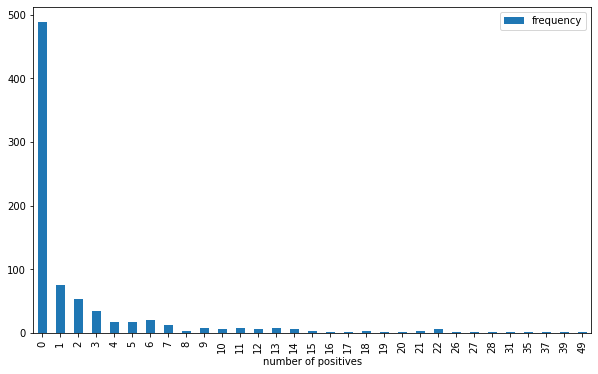

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

sfn_report_df = pd.DataFrame({"query": [i for i in range(len(positives_per_query))], "positive references count": [len(l) for l in positives_per_query]})
sfn_report_df = sfn_report_df.groupby(["positive references count"]).size().reset_index()
sfn_report_df.columns = ["number of positives", "frequency"]
sfn_report_df.plot.bar("number of positives", "frequency", figsize=(10, 6))

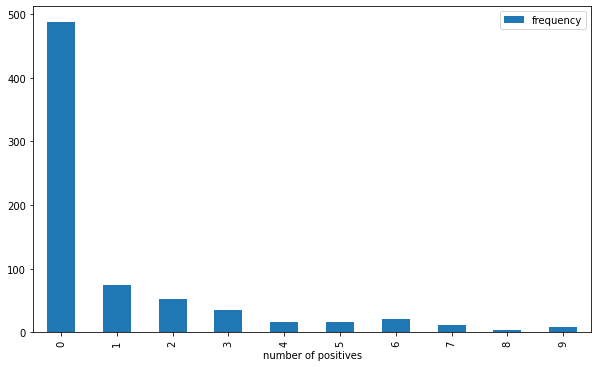

In [25]:
sfn_report_df.head(10).plot.bar("number of positives", "frequency", figsize=(10, 6))

In [26]:
sfn_report_df

,number of positives,frequency
0,0,488
1,1,75
2,2,53
3,3,35
4,4,17
5,5,17
6,6,21
7,7,12
8,8,4
9,9,8


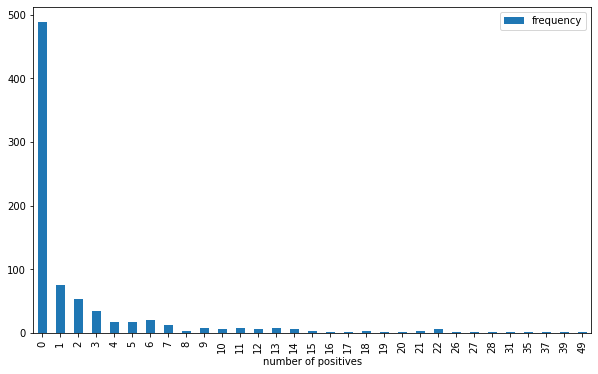

In [27]:
ax = sfn_report_df.plot.bar("number of positives", "frequency", figsize=(10, 6))
ax.figure.savefig('SF-N_positives.eps', format='eps')

In [28]:
############# tokyo visualization

In [19]:
model.to("cuda")
recalls1, recalls_str1, patch_refined_recalls1, patch_refined_recalls_str1 = test_with_postprocessing(args, test_ds_tokyo, model, patch_size=3)
recalls1, recalls_str1, patch_refined_recalls1, patch_refined_recalls_str1

100%|█████████████████████████████████████████████████████████████| 315/315 [00:03<00:00, 98.77it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in multiply


(array([81.9047619 , 91.42857143, 93.96825397, 95.55555556]),
 'R@1: 81.9, R@5: 91.4, R@10: 94.0, R@20: 95.6',
 array([86.34920635, 93.01587302, 95.23809524, 95.55555556]),
 'R@1: 86.3, R@5: 93.0, R@10: 95.2, R@20: 95.6')

In [20]:
import pandas as pd

top_pred = []
top_reranked_pred = []
top_is_correct = []
top_re_is_correct = []

for pred, re_pred, pos in zip(predictions, reranked_predictions, positives_per_query):
  top_pred.append(pred[0])
  top_reranked_pred.append(re_pred[0])
  top_is_correct.append(pred[0] in pos)
  top_re_is_correct.append(re_pred[0] in pos)

summary_df = pd.DataFrame({"pred": top_pred, "reranked_pred": top_reranked_pred, "pred_is_correct": top_is_correct, "reranked_is_correct": top_re_is_correct})

In [21]:
summary_df[summary_df["pred_is_correct"] & (~summary_df["reranked_is_correct"])]["pred"].count()/summary_df["pred"].count()

0.03492063492063492

In [22]:
summary_df[summary_df["reranked_is_correct"] & (~summary_df["pred_is_correct"])]["pred"].count()/summary_df["pred"].count()

0.07936507936507936

In [23]:
negative_df = summary_df[summary_df["pred_is_correct"] & (~summary_df["reranked_is_correct"])]

In [24]:
positive_df = summary_df[summary_df["reranked_is_correct"] & (~summary_df["pred_is_correct"])]

In [25]:
negative_df.head(7)

,pred,reranked_pred,pred_is_correct,reranked_is_correct
26,1492,9564,True,False
76,3786,11788,True,False
77,3786,8322,True,False
86,3936,3418,True,False
128,5642,5696,True,False
190,7054,6250,True,False
191,6974,4640,True,False


In [26]:
positive_df.head()

,pred,reranked_pred,pred_is_correct,reranked_is_correct
7,814,767,False,True
20,236,1435,False,True
21,1552,1436,False,True
22,1552,1436,False,True
32,4199,2240,False,True


In [39]:
from patch_matcher import torch_nn, calc_keypoint_centers_from_patches
import cv2
import numpy as np
import matplotlib.pyplot as plt


def right_scale_image(img):
  mean=[0.485, 0.456, 0.406]
  std=[0.229, 0.224, 0.225]

  img = img.copy()
  img[:, :, 0] = img[:, :, 0] * std[0] + mean[0]
  img[:, :, 1] = img[:, :, 1] * std[1] + mean[1]
  img[:, :, 2] = img[:, :, 2] * std[2] + mean[2]

  return img


def finda_mutuals_and_keypoints(qfeat, dbfeats, output_shape_q, output_shape_db, patch_size=5, stride=1):
        keypoints_q = calc_keypoint_centers_from_patches(output_shape_q, stride=1)
        keypoints_db = calc_keypoint_centers_from_patches(output_shape_db, stride=1)

        qfeat = torch.FloatTensor(qfeat)
        dbfeats = torch.FloatTensor(dbfeats)

        fw_inds, bw_inds = torch_nn(qfeat, dbfeats)
        fw_inds = fw_inds.cpu().numpy()
        bw_inds = bw_inds.cpu().numpy()

        mutuals = np.atleast_1d(np.argwhere(bw_inds[fw_inds] == np.arange(len(fw_inds))).squeeze())

        return keypoints_q, keypoints_db, mutuals, fw_inds[mutuals] 

        if len(mutuals) > 0:
            index_keypoints = keypoints_db[:, mutuals]
            query_keypoints = keypoints_q[:, fw_inds[mutuals]]

            index_keypoints = np.transpose(index_keypoints)
            query_keypoints = np.transpose(query_keypoints)

            _, mask = cv2.findHomography(index_keypoints, query_keypoints, cv2.FM_RANSAC, ransacReprojThreshold=stride*1.5)

            inlier_index_keypoints = index_keypoints[mask.ravel() == 1]
            inlier_count = inlier_index_keypoints.shape[0]
            s_score = -inlier_count / qfeat.shape[1]

        else:
            index_keypoints = []
            query_keypoints = []

        return query_keypoints, index_keypoints


def keypoints_resize(keypoints, input_size, output_size):
  size_ratio = input_size/output_size

  keypoints = keypoints.copy()
  keypoints[0] = keypoints[0] *size_ratio[0]
  keypoints[1] = keypoints[1] *size_ratio[1]
  keypoints = keypoints.astype(np.int32)

  return keypoints


#input_size = np.array(image.numpy().shape[1:])

def draw_match_2_side(img1, kp1, img2, kp2, N, matchesMask=None):
    """Draw matches on 2 sides
    Args:
        img1 (HxW(xC) array): image 1
        kp1 (Nx2 array): keypoint for image 1
        img2 (HxW(xC) array): image 2
        kp2 (Nx2 array): keypoint for image 2
        N (int): number of matches to draw
    Returns:
        out_img (Hx2W(xC) array): output image with drawn matches
    """

    kp_list = np.linspace(0, min(kp1.shape[0], kp2.shape[0])-1, N,
                                            dtype=np.int
                                            )
    
    # Convert keypoints to cv2.Keypoint object
    cv_kp1 = [cv2.KeyPoint(x=pt[0], y=pt[1], _size=1) for pt in kp1[kp_list]]
    cv_kp2 = [cv2.KeyPoint(x=pt[0], y=pt[1], _size=1) for pt in kp2[kp_list]]

    out_img = np.array([])
    good_matches = [cv2.DMatch(_imgIdx=0, _queryIdx=idx, _trainIdx=idx,_distance=0) for idx in range(N)]
    out_img = cv2.drawMatches(np.uint8(255*img1), cv_kp1, np.uint8(255*img2), cv_kp2, matches1to2=good_matches, outImg=out_img, matchColor = (0,255,0), matchesMask=matchesMask)

    return out_img 


def plot_matches(image1, image2, local_1, local_2, output_shape_1, output_shape_2, patch_size, stride, inliner=False, ransac_treshold=1.5):
  keypoints_1, keypoints_2, mutuals_2, mutuals_1 = finda_mutuals_and_keypoints(local_1, local_2, output_shape_1, output_shape_2, patch_size=patch_size, stride=stride)
  
  keypoints_1 = keypoints_1[:, mutuals_1]
  keypoints_2 = keypoints_2[:, mutuals_2]

  if inliner:
    _, mask = cv2.findHomography(np.transpose(keypoints_2), np.transpose(keypoints_1), cv2.FM_RANSAC, ransacReprojThreshold=stride*ransac_treshold)
    mask = mask.ravel().tolist()

  else:
    mask = None

  keypoints_1 = keypoints_resize(keypoints_1, np.array(image1.numpy().shape[1:]), output_shape_1)
  keypoints_2 = keypoints_resize(keypoints_2, np.array(image2.numpy().shape[1:]), output_shape_2)


  keypoints_1 = np.transpose(keypoints_1)
  keypoints_2 = np.transpose(keypoints_2)

  out_img = draw_match_2_side(right_scale_image(image1.permute([1, 2, 0]).numpy()),
                  keypoints_1,
                  right_scale_image(image2.permute([1, 2, 0]).numpy()),
                  keypoints_2,
                  keypoints_1.shape[0],
                  matchesMask=mask)

  fig, ax = plt.subplots(figsize=(15, 15))
  ax.get_xaxis().set_ticks([])
  ax.get_yaxis().set_ticks([])

  ax.imshow(out_img) 
  plt.show()

In [40]:
query_index = 7

pred_index, rk_pred_index = summary_df.iloc[query_index][["pred",	"reranked_pred"]]
query_image, q_db_index = queries_subset_ds[query_index]
pred_image, _ = database_subset_ds[pred_index]
rk_pred_image, rkpred_index = database_subset_ds[rk_pred_index]

q_local = queries_local_descriptors[query_index]
p_local = database_local_descriptors[pred_index]
rk_local = database_local_descriptors[rk_pred_index]

output_shape_q = all_output_shape_q[query_index]
positive_list = positives_per_query[query_index]

day_query_image = query_image
day_query_local = q_local

positive_list, rkpred_index

(array([684, 683, 682, 701, 697, 685, 696, 698, 699, 700, 703, 704, 702,
        716, 714, 715, 713, 717, 718, 744, 740, 741, 743, 742, 832, 831,
        836, 769, 768, 767, 835, 833, 834, 884, 766, 765, 885, 764]), 767)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:80: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


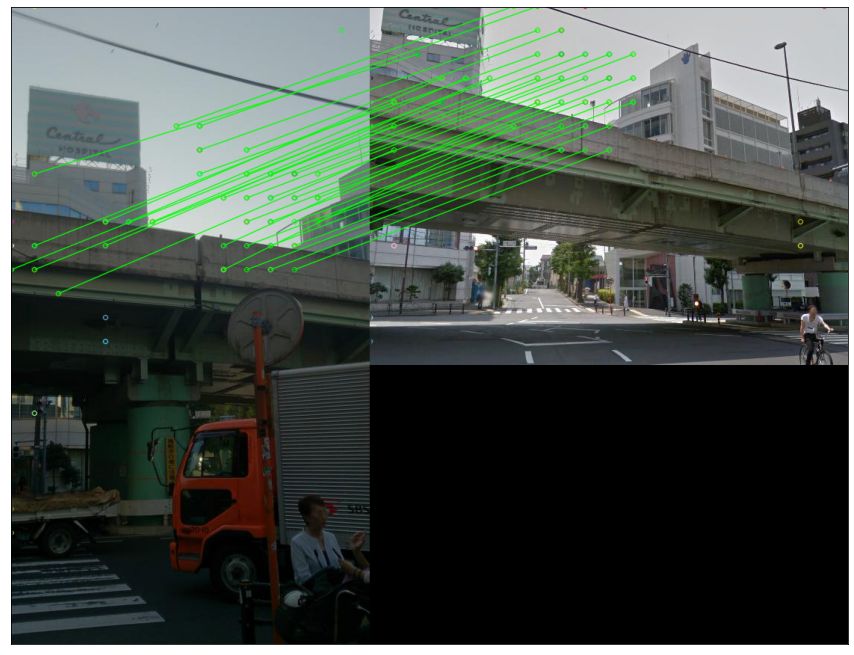

In [41]:
plot_matches(day_query_image, rk_pred_image, day_query_local, rk_local, output_shape_q, output_shape_db, 3, 1, inliner=True, ransac_treshold=1.5)

In [42]:
query_index = 8
pred_index, rk_pred_index = summary_df.iloc[query_index][["pred",	"reranked_pred"]]
query_image, q_db_index = queries_subset_ds[query_index]
pred_image, _ = database_subset_ds[pred_index]
rk_pred_image, rkpred_index = database_subset_ds[rk_pred_index]

q_local = queries_local_descriptors[query_index]
p_local = database_local_descriptors[pred_index]
rk_local = database_local_descriptors[rk_pred_index]

output_shape_q = all_output_shape_q[query_index]
positive_list = positives_per_query[query_index]

positive_list, rkpred_index

(array([684, 683, 682, 701, 697, 685, 696, 698, 699, 700, 703, 704, 702,
        716, 714, 715, 713, 717, 718, 744, 740, 741, 743, 742, 832, 831,
        836, 769, 768, 767, 835, 833, 834, 884, 766, 765, 885, 764]), 766)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:80: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


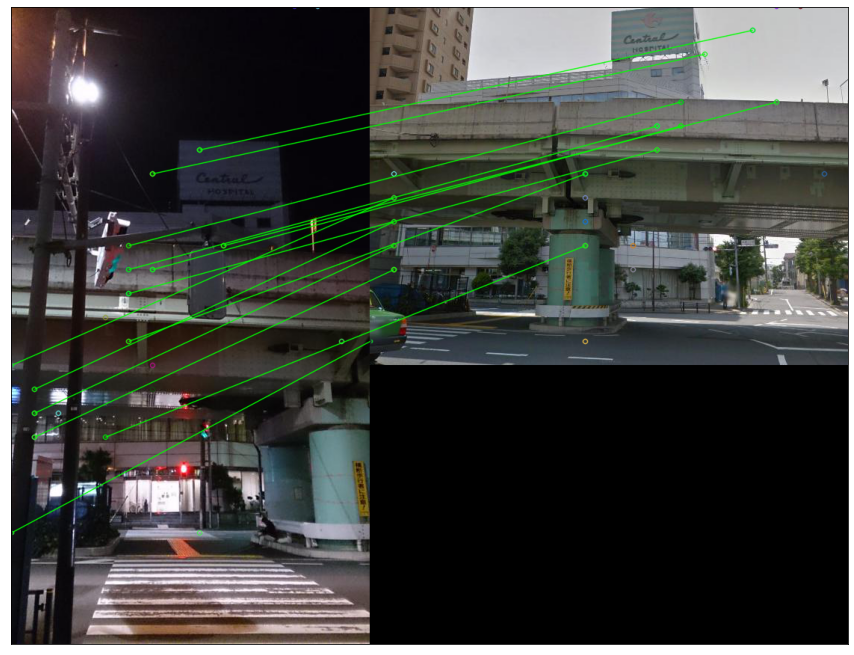

In [43]:
plot_matches(query_image, rk_pred_image, day_query_local, rk_local, output_shape_q, output_shape_db, 3, 1, inliner=True, ransac_treshold=1.5)